In [1]:
from pathlib import Path

import numpy as np
from numba import njit

In [2]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

### Load and prepare data

In [3]:
img_size = 784
img_shape = (28, 28)

train_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_test.csv'), delimiter=',')

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot_encoding(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot_encoding(10, int(i)) for i in test_data[:,0]])

### Activation funcitons

In [5]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)

@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)

@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Model

In [36]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, c: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dc = np.zeros(c.shape)

    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    U = np.zeros((V.shape[0], V.shape[1]))
    H = np.zeros((V.shape[0], V.shape[1]))
    
    for i in range(x_batch.shape[0]):
        for j in range(V.shape[0]):
            U[j] = V[j] @ x_batch[i] + c[j]
            H[j] = sigmoid(U[j])
        
        z = np.sum(H * W, axis=0) + b

        y = softmax(z)

        for j in range(V.shape[0]):
            dLdu = (y - y_batch[i]) * W[j] * dSigmoid(U[j])
            dV[j] += np.outer(dLdu , x_batch[i])
            dc[j] += dLdu
        
        dW += H * (y - y_batch[i])
        db += y - y_batch[i]
    
    return (dV, dc, dW, db)


class WidePerceptron:
    def __init__(self, nIn: int, nOut: int, nL:int) -> None:
        self.nIn = nIn
        self.nL = nL
        self.nOut = nOut
        
        self.V: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))
        self.c: np.ndarray = np.zeros((nL, nOut))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        H = np.zeros((self.nL, self.nOut))

        for i in range(self.nL):
            H[i] = sigmoid(self.V[i] @ x + self.c[i])
        
        z = np.sum(H * self.W, axis=0) + self.b
                
        return softmax(z)
    
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(Ypred), axis=1)
        return np.mean(h)
    
    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n // batch_size):
                ibegin = batch_idx * batch_size
                iend = min((batch_idx + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]
            
                dV, dc, dW, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.V, self.c, self.W, self.b)

                self.V -= lr * dV
                self.c -= lr * dc

                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [10]:
nIn = 784
nL = 16
nOut = 10

lr = 1e-2
batch_size = 128
max_epoch = 8

model = WidePerceptron(nIn, nOut, nL)

print('untrained loss: {0:.6f}'.format(model.loss(x_test, y_test)))

model.train(x_train, y_train, lr, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(x_test, y_test)))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss: 0.355457
trained loss: 0.025044
test set accuracy: 92.64%


### Visualize learned output features

In [57]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

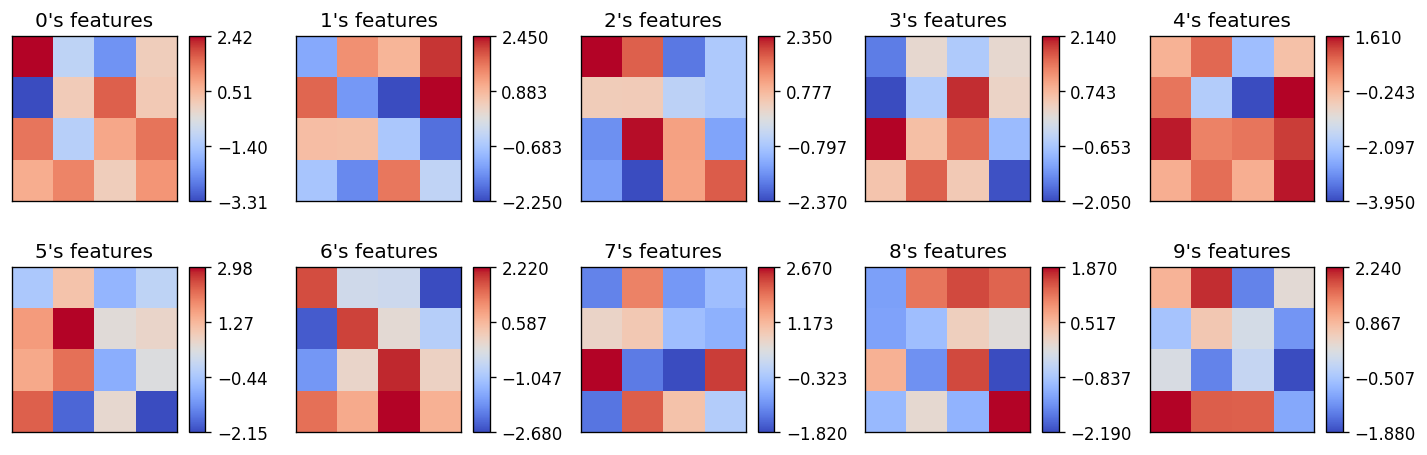

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=5)

fig.set_dpi(120)
fig.set_figwidth(12)
fig.set_figheight(4)

W_T = model.W.T

for i, ax in enumerate(axes.ravel()):
    img = ax.imshow(W_T[i].reshape((4, 4)), cmap='coolwarm')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.1)

    cbar = fig.colorbar(img, ax=ax, cax=cax)
    cmin = round(np.min(W_T[i]), 2)
    cmax = round(np.max(W_T[i]), 2)
    cbar.set_ticks(np.linspace(cmin, cmax, 4))

    ax.set_title(f'{i}\'s features')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Visualize features similarity

In [91]:
from math import sqrt

In [98]:
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


def m_self_cosim(m: np.ndarray) -> np.ndarray:    
    norms = np.apply_along_axis(norm, 1, m)
    return (m @ m.T) / np.outer(norms, norms)

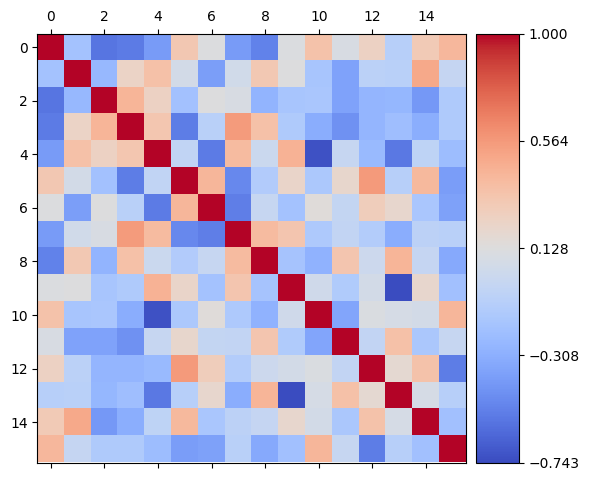

In [105]:
fetures_similarity = m_self_cosim(model.W)

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot()

img = ax.matshow(fetures_similarity, cmap='coolwarm')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)

cbar = fig.colorbar(img, ax=ax, cax=cax)
cmin = np.min(fetures_similarity)
cmax = np.max(fetures_similarity)
cbar.set_ticks(np.linspace(cmin, cmax, 5))

plt.tight_layout()
plt.show()